<a href="https://colab.research.google.com/github/S-EGK/Contollers/blob/main/Non-Linear%20Controllers/Backstepping%20Sliding%20Mode%20Trajectory%20Controller%20for%20Quadrotor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
# importing libraries
from math import cos, sin, sqrt
import numpy as np
from random import random
import scipy.signal as signal
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle
from IPython.display import HTML

## Parameters

### System Parameters

In [ ]:
#States
x1 = 0 #roll
x2 = 0 #roll rate
x3 = 0 #pitch
x4 = 0 #pitch rate
x5 = 0 #yaw
x6 = 0 #yaw rate
x7 = 0 #x-pos
x8 = 0 #x-vel
x9 = 0 #y-pos
x10 = 0 #y-vel
x11 = 0 #z-pos
x12 = 0 #z-vel

states = np.array([x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12])

#Backstepping SMC gains
rho1 = 0.9
rho2 = 0.9
rho3 = 0.9
rho4 = 0.9
rho5 = 0.9
rho6 = 0.9

# SMC gains
c1 = 20
k1 = 20
c2 = 20
k2 = 20
c3 = 0.9
k3 = 0.9

# Epsilon 
e11 = 0.9
e21 = 0.9
e31 = 0.9

### Data Collectors

In [ ]:
x1_data = []
x2_data = []
x3_data = []
x4_data = []
x5_data = []
x6_data = []
x7_data = []
x8_data = []
x9_data = []
x10_data = []
x11_data = []
x12_data = []

x_r_data = []
y_r_data = []
z_r_data = []
psi_r_data = []

x1d_data = []
x3d_data = []

U1_data = []
U2_data = []
U3_data = []
U4_data = []

### Quad Parameters

In [ ]:
dx = 0.25
dy = 0.25
dz = 0.25
dph = 0.2
dth = 0.2
dps = 0.2
m = 1
g = 9.8
Jx = 0.114700 #moi wrt x
Jy = 0.057600 #moi wrt y
Jz = 0.171200 #moi wrt z
Jr = sqrt(Jx*Jx+Jy*Jy+Jz*Jz)

### Normalized Parameters

In [ ]:
a1 = (Jy-Jz)/Jx
a2 = Jr/Jx
a3 = dph/Jx
a4 = (Jz-Jx)/Jy
a5 = Jr/Jy
a6 = dth/Jy
a7 = (Jx-Jy)/Jz
a8 = dps/Jz
a9 = dx/m
a10 = dy/m
a11 = dz/m

w_bar = 0.9

### Simulation Parameters

In [ ]:
dt = 0.1
Tfinal = 40
Ts = dt
Tsteps = Tfinal/Ts # number of frames
frames = int(Tsteps)

## Transformation Matrices

In [ ]:
# Rotational Matrix to convert body frame to inertial frame
def rot_mat_bod2veh(phi, theta, psi):
    R_b_v=np.array([[cos(theta)*cos(psi), sin(phi)*sin(theta)*cos(psi)-cos(phi)*sin(psi), cos(phi)*sin(theta)*cos(psi)+sin(phi)*sin(psi)],
                    [cos(theta)*sin(psi), sin(phi)*sin(theta)*sin(psi)+cos(phi)*cos(psi), cos(phi)*sin(theta)*sin(psi)-sin(phi)*cos(psi)],
                    [-sin(theta),         sin(phi)*cos(theta),                            cos(phi)*cos(theta)]])
    return R_b_v

In [ ]:
# Matrix to orient ned to xyz
def axes_ned2yxz():
  A_ned = [[0, 1, 0],
           [1, 0, 0],
           [0, 0, -1]]
  return A_ned

## Reference Trajectory

In [ ]:
def ref_traj(t):
  x_r = np.cos(t)
  x_r_dot = -np.sin(t)
  x_r_ddot = -np.cos(t)
  x_ref = np.array([x_r, x_r_dot, x_r_ddot])

  x_r_data.append(x_r)

  y_r = np.sin(t)
  y_r_dot = np.cos(t)
  y_r_ddot = -np.sin(t)
  y_ref = np.array([y_r, y_r_dot, y_r_ddot])

  y_r_data.append(y_r)

  z_r = 0.5*t
  z_r_dot = 0.5
  z_r_ddot = 0
  z_ref = np.array([z_r, z_r_dot, z_r_ddot])

  z_r_data.append(z_r)

  psi_r = np.sin(0.5*t)
  psi_r_dot = 0.5*np.cos(0.5*t)
  psi_r_ddot = -0.5*0.5*np.sin(0.5*t)
  psi_ref = np.array([psi_r, psi_r_dot, psi_r_ddot])

  psi_r_data.append(psi_r)

  return x_ref, y_ref, z_ref, psi_ref

## Backstepping Sliding Mode Controller for Position Trajectory Tracking Control 

In [ ]:
def pos_ctrl(states, x_ref, y_ref, z_ref):
  x1 = states[0] + np.random.normal(0, 0.1)
  x2 = states[1]
  x3 = states[2] + np.random.normal(0, 0.1)
  x4 = states[3]
  x5 = states[4] + np.random.normal(0, 0.1)
  x6 = states[5]
  x7 = states[6] + np.random.normal(0, 0.1)
  x8 = states[7]
  x9 = states[8] + np.random.normal(0, 0.1)
  x10 = states[9]
  x11 = states[10] + np.random.normal(0, 0.1)
  x12 = states[11]

  # Block for x-pos
  z7 = x_ref[0] - x7                    # x-pos error state
  v1 = x_ref[1] + rho1*z7               # virtual control 1
  sp1 = v1 - x8                         # sliding-mode manifold
  z7_dot = -rho1*z7 + sp1               # rate change of error state
  v1_dot = x_ref[2] + rho1*z7_dot       # rate change of virtual control 1
  v2 = v1_dot + z7 + a9*x8 + rho2*sp1   # virtual control 2

  # Block for y-pos
  z9 = y_ref[0] - x9                    # y-pos error state
  v3 = y_ref[1] + rho3*z9               # virtual control 3
  sp2 = v3 - x10                        # sliding-mode manifold
  z9_dot = -rho3*z9 + sp2               # rate change of error state
  v3_dot = y_ref[2] + rho3*z9_dot       # rate change of virtual control 3
  v4 = v3_dot + z9 + a10*x10 + rho4*sp2 # virtual control 4

  # Block for z-pos
  z11 = z_ref[0] - x11                        # y-pos error state
  v5 = z_ref[1] + rho5*z11                    # virtual control 3
  sp3 = v5 - x12                              # sliding-mode manifold
  z11_dot = -rho5*z11 + sp3                   # rate change of error state
  v5_dot = z_ref[2] + rho5*z11_dot            # rate change of virtual control 2
  v6 = v5_dot + z11 + g + a11*x12 + rho6*sp3  # virtual control 2

  return v2, v4, v6

## Arithmatic Inverter

In [ ]:
def art_invt(t, states):
  x1 = states[0]
  x2 = states[1]
  x3 = states[2]
  x4 = states[3]
  x5 = states[4]
  x6 = states[5]
  x7 = states[6]
  x8 = states[7]
  x9 = states[8]
  x10 = states[9]
  x11 = states[10]
  x12 = states[11]

  x1d = np.arctan2(-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)), sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))
  x3d = np.arctan2(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11), sin(sin(0.5*t)) + cos(sin(0.5*t)))

  x1d_dot = ((sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) - (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*((0.5*rho5*rho6 + 0.5)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*cos(sin(0.5*t)) + ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) - 0.5*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2)
  x1d_ddot = (0.5*rho5*rho6 + 0.5)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*cos(sin(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/(((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)) + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) - (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*(2*(0.5*rho5*rho6 + 0.5)*((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*cos(sin(0.5*t))/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) - 1.0*(0.5*rho5*rho6 + 0.5)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*sin(sin(0.5*t))*cos(0.5*t) + (-(-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 - (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)**(3/2) - 1.0*((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) +    rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t)/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) + 0.25*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(0.5*t)*sin(sin(0.5*t)) - 0.25*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(0.5*t)**2*cos(sin(0.5*t)) + ((-0.5*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t))/2)*(-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t))) + (sin(sin(0.5*t)) + cos(sin(0.5*t)))*(0.25*sin(0.5*t)*sin(sin(0.5*t)) - 0.25*sin(0.5*t)*cos(sin(0.5*t)) - 0.25*sin(sin(0.5*t))*cos(0.5*t)**2 - 0.25*cos(0.5*t)**2*cos(sin(0.5*t))) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(rho1*sin(t) + rho2*(-rho1*cos(t) + sin(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-0.5*rho5*rho6 - 0.5)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2 + (-rho3*cos(t) + rho4*(-rho3*sin(t) - cos(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-1.0*rho5*rho6 - 1.0)*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**3))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) - (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*((0.5*rho5*rho6 + 0.5)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*cos(sin(0.5*t)) + ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) - 0.5*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*(-(rho5*rho6 + 1.0)*((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))**2 - ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t))) + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2 - (-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*(2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + 2*(0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + 2*(0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + 2*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 1.0*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t)) + 1.0*((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*sin(sin(0.5*t))*cos(0.5*t)*cos(sin(0.5*t)))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2)**2 - 0.5*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t)/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*(2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t))) + (-rho3*cos(t) + rho4*(-rho3*sin(t) - cos(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + 2*(0.5*rho5*rho6 + 0.5)*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*cos(sin(0.5*t)) + (0.5*rho5*rho6 + 0.5)*(-0.5*a9*x8 - 0.5*rho1*(-x8 - sin(t)) - 0.5*rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + 0.5*x7 - 0.5*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*sin(sin(0.5*t))*cos(0.5*t) - 0.5*(0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*sin(sin(0.5*t))*cos(0.5*t) + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)*(-0.25*sin(0.5*t)*sin(sin(0.5*t)) + 0.25*sin(0.5*t)*cos(sin(0.5*t)) + 0.25*sin(sin(0.5*t))*cos(0.5*t)**2 + 0.25*cos(0.5*t)**2*cos(sin(0.5*t))) - 0.5*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t) + (0.5*rho1*cos(t) - 0.5*rho2*(-rho1*sin(t) - cos(t)) - 0.5*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) - 0.5*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t) - 0.5*(-0.5*a9*x8 - 0.5*rho1*(-x8 - sin(t)) - 0.5*rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + 0.5*x7 - 0.5*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(0.5*t)*sin(sin(0.5*t)) + 0.5*(-0.5*a9*x8 - 0.5*rho1*(-x8 - sin(t)) - 0.5*rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + 0.5*x7 - 0.5*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(0.5*t)**2*cos(sin(0.5*t)) + (rho1*sin(t) + rho2*(-rho1*cos(t) + sin(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-0.5*rho5*rho6 - 0.5)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2 + (-rho3*cos(t) + rho4*(-rho3*sin(t) - cos(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-1.0*rho5*rho6 - 1.0)*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**3)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*cos(sin(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + ((0.5*rho5*rho6 + 0.5)*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*cos(sin(0.5*t)) + ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))/2 + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) - 0.5*sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(-a9*x8 - rho1*(-x8 - sin(t)) - rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + x7 - (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (rho1*cos(t) - rho2*(-rho1*sin(t) - cos(t)) - (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) - (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(-a9*x8 - rho1*(-x8 - sin(t)) - rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + x7 - (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2) + sqrt((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(-(rho5*rho6 + 1.0)*((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))**2 - ((-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t))) + (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2 - (-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))*(2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + 2*(0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + 2*(0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + 2*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 1.0*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t)) + 1.0*((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*sin(sin(0.5*t))*cos(0.5*t)*cos(sin(0.5*t)))*((-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-sin(sin(0.5*t)) - cos(sin(0.5*t))) + (0.5*rho5*rho6 + 0.5)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*cos(sin(0.5*t)) + (0.5*sin(sin(0.5*t))*cos(0.5*t) - 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)) - 0.5*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*sin(sin(0.5*t))*cos(0.5*t))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t))/((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2)**2

  x3d_dot = (-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(-a9*x8 - rho1*(-x8 - sin(t)) - rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + x7 - (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) + (sin(sin(0.5*t)) + cos(sin(0.5*t)))*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)
  x3d_ddot = (-(-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t))) - (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)))*(-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(-a9*x8 - rho1*(-x8 - sin(t)) - rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + x7 - (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)**2 + (-(-1.0*sin(sin(0.5*t))*cos(0.5*t) + cos(0.5*t)*cos(sin(0.5*t)))*(sin(sin(0.5*t)) + cos(sin(0.5*t))) - (-2*rho1*cos(t) + 2*rho2*(-rho1*sin(t) - cos(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + 2*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)*(a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)))*(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)**2 + (-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(-rho1*cos(t) + rho2*(-rho1*sin(t) - cos(t)) + (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) + (-0.5*sin(sin(0.5*t))*cos(0.5*t) + 0.5*cos(0.5*t)*cos(sin(0.5*t)))*(rho1*cos(t) - rho2*(-rho1*sin(t) - cos(t)) - (-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) - (-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) + (sin(sin(0.5*t)) + cos(sin(0.5*t)))*(rho1*sin(t) + rho2*(-rho1*cos(t) + sin(t)) + 2*(-rho3*sin(t) + rho4*(rho3*cos(t) - sin(t)))*(-0.5*rho5*rho6 - 0.5)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2 + (-rho3*cos(t) + rho4*(-rho3*sin(t) - cos(t)))/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11) + (-1.0*rho5*rho6 - 1.0)*(-0.5*rho5*rho6 - 0.5)*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**3)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2) + (0.25*sin(0.5*t)*sin(sin(0.5*t)) - 0.25*sin(0.5*t)*cos(sin(0.5*t)) - 0.25*sin(sin(0.5*t))*cos(0.5*t)**2 - 0.25*cos(0.5*t)**2*cos(sin(0.5*t)))*(-a9*x8 - rho1*(-x8 - sin(t)) - rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) + x7 - (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))/((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)

  x1_d = np.array([x1d,x1d_dot,x1d_ddot])
  x3_d = np.array([x3d,x3d_dot,x3d_ddot])

  U4 = ((-(sin(sin(0.5*t)) + cos(sin(0.5*t)))*(a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9) + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)*cos(sin(0.5*t)))**2 + ((sin(sin(0.5*t)) + cos(sin(0.5*t)))**2 + (a9*x8 + rho1*(-x8 - sin(t)) + rho2*(rho1*(-x7 + cos(t)) - x8 - sin(t)) - x7 + (a10*x10 + rho3*(-x10 + cos(t)) + rho4*(rho3*(-x9 + sin(t)) - x10 + cos(t)) - x9)/(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11))**2)*(a11*x12 + g + rho5*(0.5 - x12) + rho6*(rho5*(0.5*t - x11) - x12 + 0.5) + 0.5*t - x11)**2*cos(sin(0.5*t))**2)/((sin(sin(0.5*t)) + cos(sin(0.5*t)))*cos(sin(0.5*t)))

  x1d_data.append(x1d)
  x3d_data.append(x3d)
  U4_data.append(U4)
  
  return x1_d, x3_d, U4

## Sliding Mode Controller for Attitude Trajectory Tracking Control

In [ ]:
def att_ctrl(states, x1d, x3d, psi_ref):
  x1 = states[0]
  x2 = states[1]
  x3 = states[2]
  x4 = states[3]
  x5 = states[4]
  x6 = states[5]
  x7 = states[6]
  x8 = states[7]
  x9 = states[8]
  x10 = states[9]
  x11 = states[10]
  x12 = states[11]

  e1_dot = x1d[1] - x2
  e1 = x1d[0] - x1
  s1 = e1_dot + c1*e1
  s11 = np.absolute(s1/e11)
  if s11 <= 1:
    u1 = s1
  elif s11 > 1:
    u1 = np.sign(s1)
  U1 = x1d[2] + c1*e1_dot - (a1*x4*x6+a2*w_bar*x4-a3*x2) + k1*u1

  e3 = x3d[0] - x3
  e3_dot = x3d[1] - x4
  s2 = e3_dot + c2*e3
  s21 = np.absolute(s2/e21)
  if s21 <= 1:
    u2 = s2
  elif s21 > 1:
    u2 = np.sign(s2)
  U2 = x3d[2] + c2*e3_dot - (a4*x2*x6+a5*w_bar*x2-a6*x4) + k2*u2

  e5 = psi_ref[0] - x5
  e5_dot = psi_ref[1] - x6
  s3 = e5_dot + c3*e5
  s31 = np.absolute(s2/e31)
  if s31 <= 1:
    u3 = s3
  elif s31 > 1:
    u3 = np.sign(s3)
  U3 = psi_ref[2] + c3*e5_dot - (a7*x2*x4-a8*x6) + k3*u3

  return U1, U2, U3

## Quadrotor Dynamics

In [ ]:
def quad_dyna(t, y, x1d, x3d, psi_ref, v2, v4, v6):
  x1 = y[0]
  x2 = y[1]
  x3 = y[2]
  x4 = y[3]
  x5 = y[4]
  x6 = y[5]
  x7 = y[6]
  x8 = y[7]
  x9 = y[8]
  x10 = y[9]
  x11 = y[10]
  x12 = y[11]

  # SMC included
  e1_dot = x1d[1] - x2
  e1 = x1d[0] - x1
  s1 = e1_dot + c1*e1
  s11 = np.absolute(s1/e11)
  if s11 <= 1:
    u1 = s1
  elif s11 > 1:
    u1 = np.sign(s1)
  x1_dot = x2
  x2_dot = x1d[2] + c1*e1_dot + k1*u1

  # SMC included
  e3 = x3d[0] - x3
  e3_dot = x3d[1] - x4
  s2 = e3_dot + c2*e3
  s21 = np.absolute(s2/e21)
  if s21 <= 1:
    u2 = s2
  elif s21 > 1:
    u2 = np.sign(s2)
  x3_dot = x4
  x4_dot = x3d[2] + c2*e3_dot + k2*u2

  # SMC included
  e5 = psi_ref[0] - x5
  e5_dot = psi_ref[1] - x6
  s3 = e5_dot + c3*e5
  s31 = np.absolute(s2/e31)
  if s31 <= 1:
    u3 = s3
  elif s31 > 1:
    u3 = np.sign(s3)
  x5_dot = x6
  x6_dot = psi_ref[2] + c3*e5_dot + k3*u3

  # Backstepping SMC included
  x7_dot = x8
  x8_dot = v2 - a9*x8

  # Backstepping SMC included
  x9_dot = x10
  x10_dot = v4 - a10*x10

  # Backstepping SMC included
  x11_dot = x12
  x12_dot = -g + v6 - a11*x12

  return x1_dot, x2_dot, x3_dot, x4_dot, x5_dot, x6_dot, x7_dot, x8_dot, x9_dot, x10_dot, x11_dot, x12_dot

## Solver

In [ ]:
def step(states, Ts, i):
  x1 = states[0]
  x2 = states[1]
  x3 = states[2]
  x4 = states[3]
  x5 = states[4]
  x6 = states[5]
  x7 = states[6]
  x8 = states[7]
  x9 = states[8]
  x10 = states[9]
  x11 = states[10]
  x12 = states[11]

  x_ref, y_ref, z_ref, psi_ref = ref_traj(i/10)

  v2, v4, v6 = pos_ctrl(states, x_ref, y_ref, z_ref)

  x1d, x3d, U4 = art_invt(i/10, states)

  U1, U2, U3 = att_ctrl(states, x1d, x3d, psi_ref)

  U1_data.append(U1)
  U2_data.append(U2)
  U3_data.append(U3)

  sol = solve_ivp(lambda t, y: quad_dyna(t, y, x1d, x3d, psi_ref, v2, v4, v6), [0, Ts], [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12], t_eval=np.linspace( 0, Ts, 10))
  states = sol.y[:,-1].T

  return states

## Simulation Setup

In [ ]:
# function to draw the quad
def build_quad(x7, x9, x11, x1, x3, x5):
  pn = x7
  pe = x9
  pd = -x11
  phi = x1
  theta = x3
  psi = x5
  
  # define width to use as reference to construct the quad 
  w = 0.75

  # defining the coordinates of the end points of the quad rotors
  p1 = np.array([w, 0, 0]).T
  p2 = np.array([-w, 0, 0]).T
  p3 = np.array([0, w, 0]).T
  p4 = np.array([0, -w, 0]).T

  # converting the quadrotor points to interial frame and translating as per ned
  R = rot_mat_bod2veh(phi, theta, psi) # rotational matrix
  pos_ned = np.array([pn, pe, pd]).T #
  p1r = np.matmul(R,p1)+pos_ned
  p2r = np.matmul(R,p2)+pos_ned
  p3r = np.matmul(R,p3)+pos_ned
  p4r = np.matmul(R,p4)+pos_ned

  # changing the orientation of ned wrt yxz
  A = axes_ned2yxz()
  p1ra = np.matmul(A,p1r)
  p2ra = np.matmul(A,p2r)
  p3ra = np.matmul(A,p3r)
  p4ra = np.matmul(A,p4r)

  # Rotor coordinates
  rot_x = [p1ra[0], p2ra[0], p3ra[0], p4ra[0]]
  rot_y = [p1ra[1], p2ra[1], p3ra[1], p4ra[1]]
  rot_z = [p1ra[2], p2ra[2], p3ra[2], p4ra[2]]

  # Arm coordinates
  arm1_x = [p1ra[0], p2ra[0]]
  arm1_y = [p1ra[1], p2ra[1]]
  arm1_z = [p1ra[2], p2ra[2]]

  arm2_x = [p3ra[0], p4ra[0]]
  arm2_y = [p3ra[1], p4ra[1]]
  arm2_z = [p3ra[2], p4ra[2]]

  # defining the coordinates of the payload
  v1 = np.array([-w/3,-w/3,w/2]).T
  v2 = np.array([-w/3,-w/3,0]).T
  v3 = np.array([w/3,-w/3,0]).T
  v4 = np.array([w/3,-w/3,w/2]).T
  v5 = np.array([w/3,w/3,w/2]).T
  v6 = np.array([w/3,w/3,0]).T
  v7 = np.array([-w/3,w/3,0]).T
  v8 = np.array([-w/3,w/3,w/2]).T

  # converting the payload points to interial frame and translating as per ned
  v1r = np.matmul(R,v1)+pos_ned
  v2r = np.matmul(R,v2)+pos_ned
  v3r = np.matmul(R,v3)+pos_ned
  v4r = np.matmul(R,v4)+pos_ned
  v5r = np.matmul(R,v5)+pos_ned
  v6r = np.matmul(R,v6)+pos_ned
  v7r = np.matmul(R,v7)+pos_ned
  v8r = np.matmul(R,v8)+pos_ned

  # changing the orientation of ned wrt yxz
  v1ra = np.matmul(A,v1r)
  v2ra = np.matmul(A,v2r)
  v3ra = np.matmul(A,v3r)
  v4ra = np.matmul(A,v4r)
  v5ra = np.matmul(A,v5r)
  v6ra = np.matmul(A,v6r)
  v7ra = np.matmul(A,v7r)
  v8ra = np.matmul(A,v8r)

  # defining the faces of the payload
  f1_x=[v1ra[0], v2ra[0], v3ra[0], v4ra[0], v1ra[0]]
  f1_y=[v1ra[1], v2ra[1], v3ra[1], v4ra[1], v1ra[1]]
  f1_z=[v1ra[2], v2ra[2], v3ra[2], v4ra[2], v1ra[2]]
  f2_x=[v5ra[0], v6ra[0], v7ra[0], v8ra[0], v5ra[0]]
  f2_y=[v5ra[1], v6ra[1], v7ra[1], v8ra[1], v5ra[1]]
  f2_z=[v5ra[2], v6ra[2], v7ra[2], v8ra[2], v5ra[2]]
  f3_x=[v4ra[0], v5ra[0], v6ra[0], v3ra[0], v4ra[0]]
  f3_y=[v4ra[1], v5ra[1], v6ra[1], v3ra[1], v4ra[1]]
  f3_z=[v4ra[2], v5ra[2], v6ra[2], v3ra[2], v4ra[2]]
  f4_x=[v1ra[0], v8ra[0], v7ra[0], v2ra[0], v1ra[0]]
  f4_y=[v1ra[1], v8ra[1], v7ra[1], v2ra[1], v1ra[1]]
  f4_z=[v1ra[2], v8ra[2], v7ra[2], v2ra[2], v1ra[2]]

  return rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z

In [ ]:
# Intial Plot
fig = plt.figure(figsize=(7,7), dpi=90)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlim((-5, 5))            
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation (y:ref, k:true)')

rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(x7, x9, x11, x1, x3, x5)

# Collecting data for trajectories and plots
x7_data.append(x7)
x9_data.append(x9)
x11_data.append(x11)

# Creatin handles for plotting and animation

# payload
face1, = ax.plot(f1_x, f1_y, f1_z, 'b', lw=1.1)
face2, = ax.plot(f2_x, f2_y, f2_z, 'r', lw=1.1)
face3, = ax.plot(f3_x, f3_y, f3_z, 'g', lw=1.1)
face4, = ax.plot(f4_x, f4_y, f4_z, 'y', lw=1.1)

# arms and rotors
arm1, = ax.plot(arm1_x, arm1_y, arm1_z, 'r-', lw=1.5)
arm2, = ax.plot(arm2_x, arm2_y, arm2_z, 'k-', lw=1.5)
rotor, = ax.plot(rot_x, rot_y, rot_z, 'bo', ms = 2)

# # trajectory
traj, = ax.plot(x9_data, x7_data, x11_data, 'k:', lw=1)
traj_ref, = ax.plot(y_r_data, x_r_data, z_r_data, 'y:', lw=1)

## Simulation

In [ ]:
def drawframe(i):
  global states
  states = step(states, dt,i)
  x1 = states[0]
  x2 = states[1]
  x3 = states[2]
  x4 = states[3]
  x5 = states[4]
  x6 = states[5]
  x7 = states[6]
  x8 = states[7]
  x9 = states[8]
  x10 = states[9]
  x11 = states[10]
  x12 = states[11]

  x1_data.append(x1)
  x2_data.append(x2)
  x3_data.append(x3)
  x4_data.append(x4)
  x5_data.append(x5)
  x6_data.append(x6)
  x7_data.append(x7)
  x8_data.append(x8)
  x9_data.append(x9)
  x10_data.append(x10)
  x11_data.append(x11)
  x12_data.append(x12)

  rot_x, rot_y, rot_z, arm1_x, arm1_y, arm1_z, arm2_x, arm2_y, arm2_z, f1_x, f1_y, f1_z, f2_x, f2_y, f2_z, f3_x, f3_y, f3_z, f4_x, f4_y, f4_z = build_quad(x7, x9, x11, x1, x3, x5)

  face1.set_data(f1_x, f1_y)
  face1.set_3d_properties(f1_z)
  face2.set_data(f2_x, f2_y)
  face2.set_3d_properties(f2_z)
  face3.set_data(f3_x, f3_y)
  face3.set_3d_properties(f3_z)
  face4.set_data(f4_x, f4_y)
  face4.set_3d_properties(f3_z)

  arm1.set_data(arm1_x, arm1_y)
  arm1.set_3d_properties(arm1_z)
  arm2.set_data(arm2_x, arm2_y)
  arm2.set_3d_properties(arm2_z)
  rotor.set_data(rot_x, rot_y)
  rotor.set_3d_properties(rot_z)

  traj.set_data(x9_data, x7_data)
  traj.set_3d_properties(x11_data)

  traj_ref.set_data(y_r_data, x_r_data)
  traj_ref.set_3d_properties(z_r_data)

  return face1, face2, face3, face4, arm1, arm2, rotor, traj, traj_ref

In [ ]:
# Creating the Simulatiom
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation (y:ref, k:true)')
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=frames, interval=40, blit=True)

In [ ]:
# Converting the animated result into a  html5 video for visualization
HTML(anim.to_html5_video())

## Plots

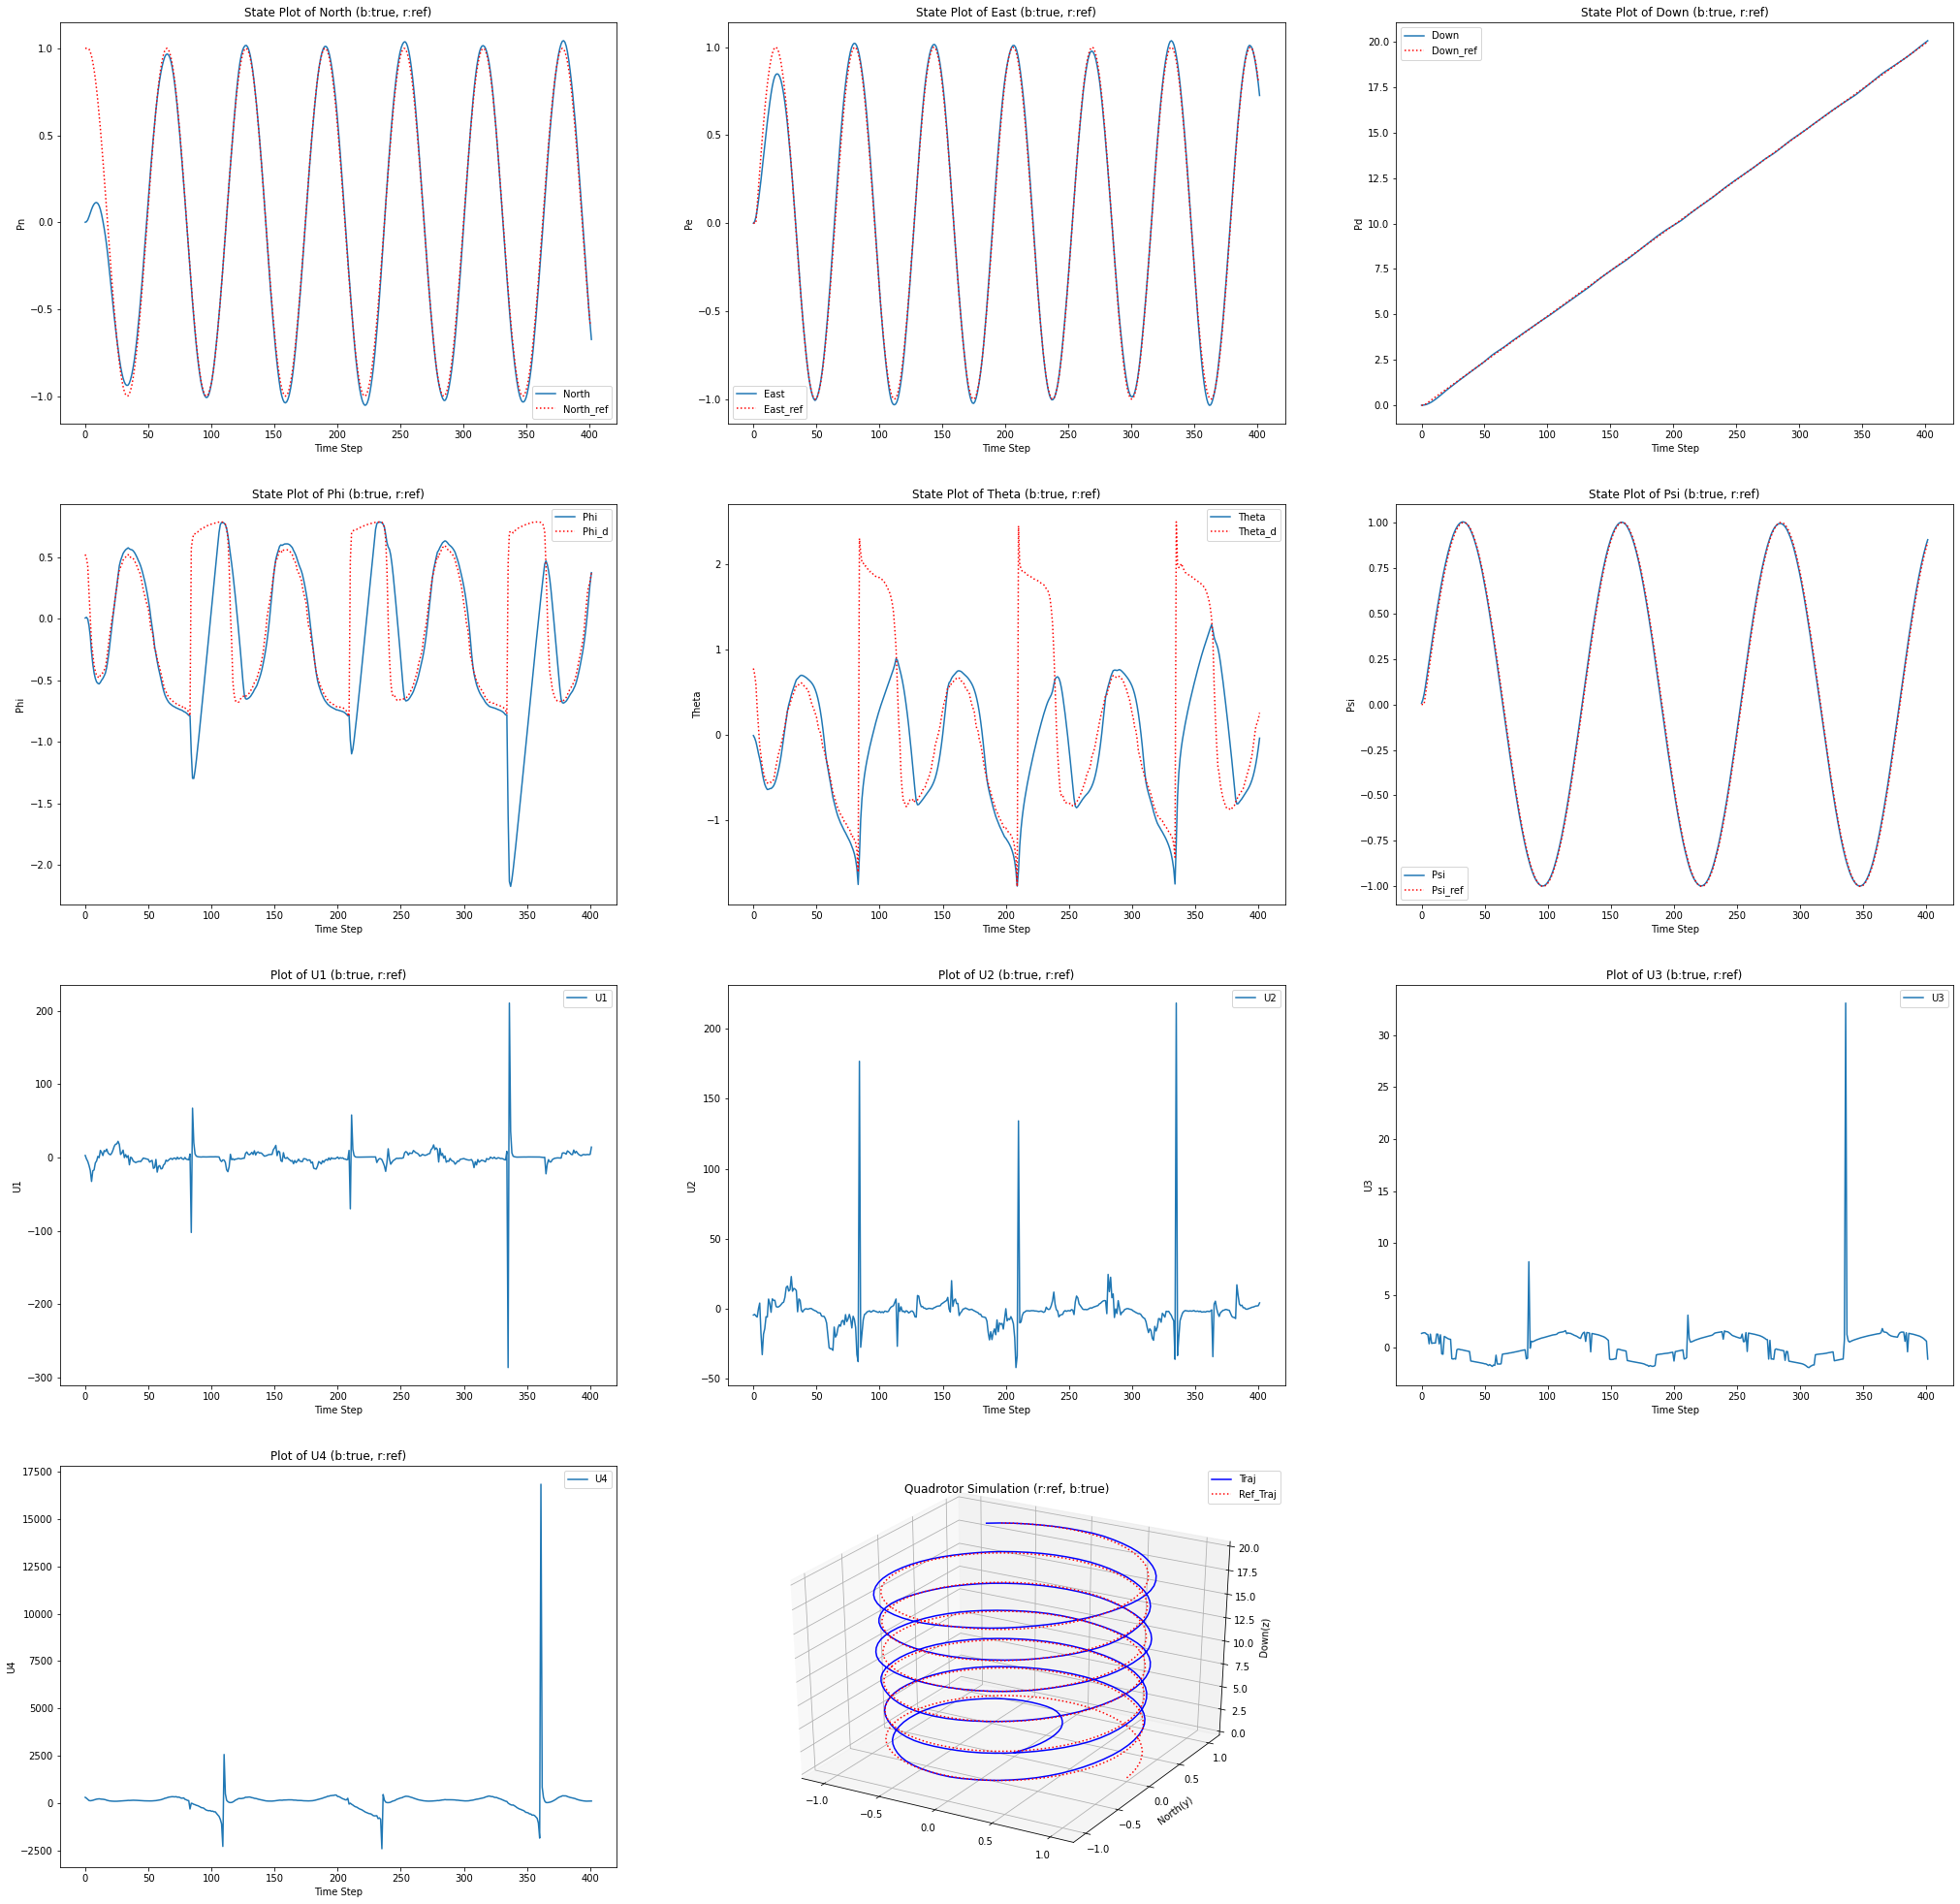

In [ ]:
fig1 = plt.figure(figsize=(35,35))
ax1 = fig1.add_subplot(4, 3, 1)
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Pn')
ax1.set_title('State Plot of North (b:true, r:ref)')
pn1 = ax1.plot(range(len(x7_data)),x7_data, label = "North")
pn1 = ax1.plot(range(len(x_r_data)),x_r_data, 'r:', label = "North_ref")
ax1.legend(loc = "best")

ax2 = fig1.add_subplot(4, 3, 2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Pe')
ax2.set_title('State Plot of East (b:true, r:ref)')
pn1 = ax2.plot(range(len(x9_data)),x9_data, label = "East")
pn1 = ax2.plot(range(len(y_r_data)),y_r_data, 'r:', label = "East_ref")
ax2.legend(loc = "best")

ax3 = fig1.add_subplot(4, 3, 3)
ax3.set_xlabel('Time Step')
ax3.set_ylabel('Pd')
ax3.set_title('State Plot of Down (b:true, r:ref)')
pn1 = ax3.plot(range(len(x11_data)),x11_data, label = "Down")
pn1 = ax3.plot(range(len(z_r_data)),z_r_data, 'r:', label = "Down_ref")
ax3.legend(loc = "best")

ax4 = fig1.add_subplot(4, 3, 4)
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Phi')
ax4.set_title('State Plot of Phi (b:true, r:ref)')
pn1 = ax4.plot(range(len(x1_data)),x1_data, label = "Phi")
pn1 = ax4.plot(range(len(x1d_data)),x1d_data, 'r:', label = "Phi_d")
ax4.legend(loc = "best")

ax5 = fig1.add_subplot(4, 3, 5)
ax5.set_xlabel('Time Step')
ax5.set_ylabel('Theta')
ax5.set_title('State Plot of Theta (b:true, r:ref)')
pn1 = ax5.plot(range(len(x3_data)),x3_data, label = "Theta")
pn1 = ax5.plot(range(len(x3d_data)),x3d_data, 'r:', label = "Theta_d")
ax5.legend(loc = "best")

ax6 = fig1.add_subplot(4, 3, 6)
ax6.set_xlabel('Time Step')
ax6.set_ylabel('Psi')
ax6.set_title('State Plot of Psi (b:true, r:ref)')
pn1 = ax6.plot(range(len(x5_data)),x5_data, label = "Psi")
pn1 = ax6.plot(range(len(psi_r_data)),psi_r_data, 'r:', label = "Psi_ref")
ax6.legend(loc = "best")

ax7 = fig1.add_subplot(4, 3, 7)
ax7.set_xlabel('Time Step')
ax7.set_ylabel('U1')
ax7.set_title('Plot of U1 (b:true, r:ref)')
pn1 = ax7.plot(range(len(U1_data)),U1_data, label = "U1")
ax7.legend(loc = "best")

ax8 = fig1.add_subplot(4, 3, 8)
ax8.set_xlabel('Time Step')
ax8.set_ylabel('U2')
ax8.set_title('Plot of U2 (b:true, r:ref)')
pn1 = ax8.plot(range(len(U2_data)),U2_data, label = "U2")
ax8.legend(loc = "best")

ax9 = fig1.add_subplot(4, 3, 9)
ax9.set_xlabel('Time Step')
ax9.set_ylabel('U3')
ax9.set_title('Plot of U3 (b:true, r:ref)')
pn1 = ax9.plot(range(len(U3_data)),U3_data, label = "U3")
ax9.legend(loc = "best")

ax10 = fig1.add_subplot(4, 3, 10)
ax10.set_xlabel('Time Step')
ax10.set_ylabel('U4')
ax10.set_title('Plot of U4 (b:true, r:ref)')
pn1 = ax10.plot(range(len(U4_data)),U4_data, label = "U4")
ax10.legend(loc = "best")

ax11 = fig1.add_subplot(4, 3, 11, projection='3d')
face1 = ax11.plot(x7_data, x9_data, x11_data, 'b', label = "Traj")
face2 = ax11.plot(x_r_data, y_r_data, z_r_data, 'r:', label = "Ref_Traj")
ax.set_xlabel('East(x)')
ax11.set_ylabel('North(y)')
ax11.set_zlabel('Down(z)')
ax11.set_title('Quadrotor Simulation (r:ref, b:true)')
ax11.legend(loc = "best")

In [ ]:
fig2 = plt.figure(figsize=(7,7), dpi=90)
ax = fig2.add_subplot(1, 1, 1, projection='3d')
face1 = ax.plot(x7_data, x9_data, x11_data, 'b', label = "Traj")
face2 = ax.plot(x_r_data, y_r_data, z_r_data, 'r:', label = "Ref_Traj")
ax.set_xlabel('East(x)')
ax.set_ylabel('North(y)')
ax.set_zlabel('Down(z)')
ax.set_title('Quadrotor Simulation (r:ref, b:true)')
ax.legend(loc = "best")

# end